In [1]:
import librosa
import scipy.signal as scipy_signal
import numpy as np
import tensorflow as tf
from hmica_learning import HMICALearner, ParallelHMICALearner
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Audio
import pandas as pd
import os

In [2]:
parents = [os.getcwd(), 'mix', '2_speaker_8000_hz']
path = os.path.join(*parents, "2speakers/wav8k/max/cv/mix/01aa010s_0.40678_40ia010v_-0.40678.wav")
path_a = os.path.join(*parents, "2speakers/wav8k/max/cv/s1/01aa010s_0.40678_40ia010v_-0.40678.wav")
path_b = os.path.join(*parents, "2speakers/wav8k/max/cv/s2/01aa010s_0.40678_40ia010v_-0.40678.wav")

mixed_signal, sr = librosa.load(path, sr=None)
source_1, sampling_rate_1 = librosa.load(path_a, sr=None)
source_2, sampling_rate_2 = librosa.load(path_b, sr=None)

In [3]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = scipy_signal.butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def lowpass_filter(data, cutoff, fs, order=55):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = scipy_signal.lfilter(b, a, data)
    return y

def high_pass_filter(data, cutoff_freq, fs, order=5):
    """
    Apply a high-pass filter to the audio data.

    :param data: The audio data as a NumPy array.
    :param cutoff_freq: The cutoff frequency of the filter in Hz.
    :param fs: The sampling rate of the audio data in Hz.
    :param order: The order of the filter.
    :return: The filtered audio data.
    """

    nyq = 0.5 * fs
    normal_cutoff = cutoff_freq / nyq
    b, a = scipy_signal.butter(order, normal_cutoff, btype='high', analog=False)
    y = scipy_signal.filtfilt(b, a, data)
    return y

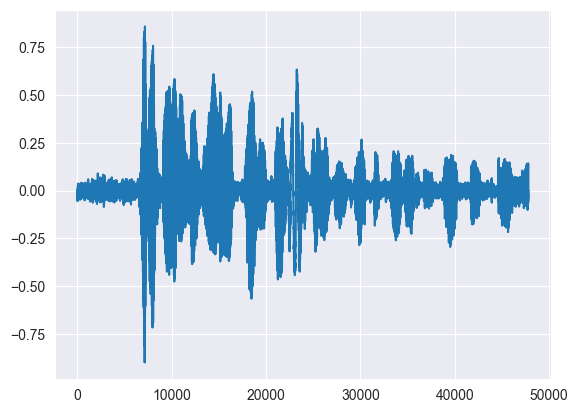

In [4]:
plt.plot(source_1)

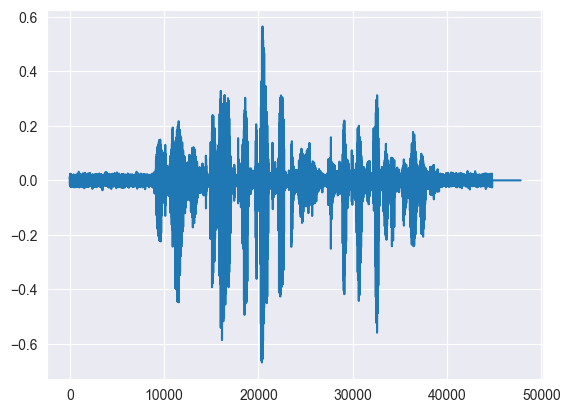

In [5]:
plt.plot(source_2)

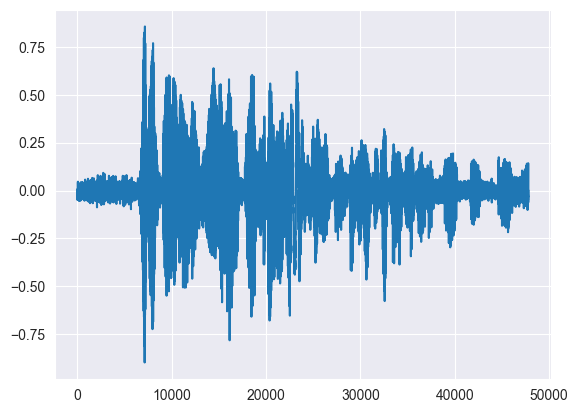

In [6]:
plt.plot(mixed_signal)

In [7]:
source_1.shape, source_2.shape, mixed_signal.shape

((47796,), (47796,), (47796,))

### Low and high pass filter to remove high frequency noise and low frequency noise

In [8]:
# source_1 = high_pass_filter(source_1, 300, sampling_rate_1) 
# source_2 = high_pass_filter(source_2, 300, sampling_rate_2)
# mixed_signal = high_pass_filter(mixed_signal, 300, sr)

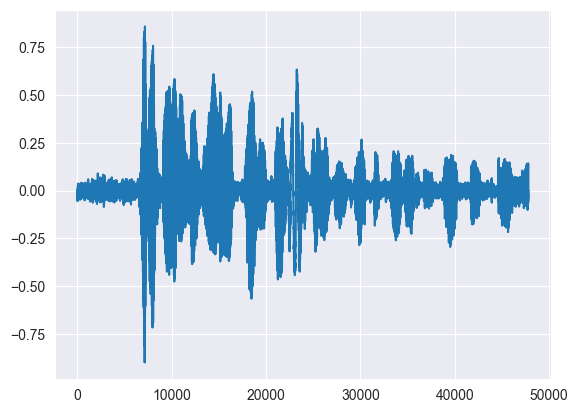

In [9]:
plt.plot(source_1)

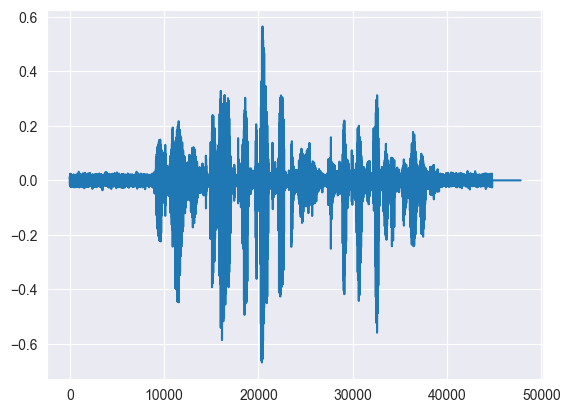

In [10]:
plt.plot(source_2)

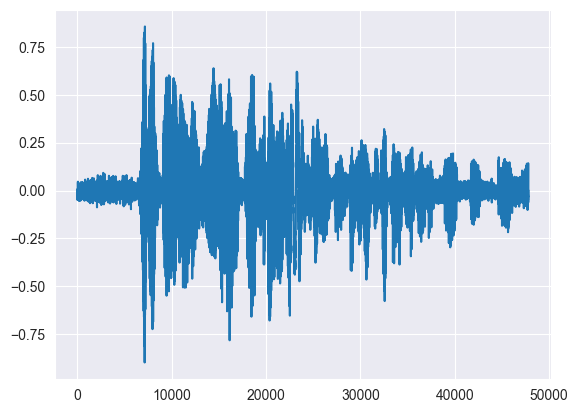

In [11]:
plt.plot(mixed_signal)

In [12]:
Audio(mixed_signal, rate=sr)

In [13]:
Audio(source_1, rate=sampling_rate_1)

In [14]:
Audio(source_2, rate=sampling_rate_2)

In [15]:
mixing_matrix = np.array([[0.6, 0.4], 
                          [0.2, 0.8]])
tmp = np.vstack((source_1, source_2))
x = mixing_matrix @ tmp 
# x = np.vstack((mixed_tmp, mixed_signal))
Audio(x, rate=sr)

In [16]:
source_1, sampling_rate_1, source_2, sampling_rate_2, tmp

(array([-0.01318359, -0.01229858, -0.01986694, ...,  0.0206604 ,
         0.00637817,  0.00152588], dtype=float32),
 8000,
 array([-0.01596069, -0.01544189, -0.00222778, ...,  0.        ,
         0.        ,  0.        ], dtype=float32),
 8000,
 array([[-0.01318359, -0.01229858, -0.01986694, ...,  0.0206604 ,
          0.00637817,  0.00152588],
        [-0.01596069, -0.01544189, -0.00222778, ...,  0.        ,
          0.        ,  0.        ]], dtype=float32))

### STFT: (Skip)

In [17]:
nperseg = 128
f, t, Zxx = scipy_signal.stft(mixed_signal, fs=sr, nperseg=nperseg, noverlap=None)
print(f'{f.shape=}, {t.shape=}, {Zxx.shape=}')

f.shape=(65,), t.shape=(748,), Zxx.shape=(65, 748)


In [18]:
# step2 - converting audio np array to spectrogram
spec = librosa.feature.melspectrogram(y=mixed_signal,
                                        sr=sr,)

In [19]:
res = librosa.feature.inverse.mel_to_audio(spec,
                                           sr=sr,)

In [20]:
Audio(res, rate=sr)

In [21]:
Audio(mixed_signal, rate=sr)

In [22]:
res[0], mixed_signal[0]

(np.float32(-0.010301102), np.float32(-0.029144287))

In [23]:

t2, x_hat = scipy_signal.istft(Zxx.real, fs=sr, nperseg=nperseg, noverlap=None)
print(f'{t2.shape=}, {x_hat.shape=}')

t2.shape=(47808,), x_hat.shape=(47808,)


In [24]:
Audio(x_hat, rate=sr)

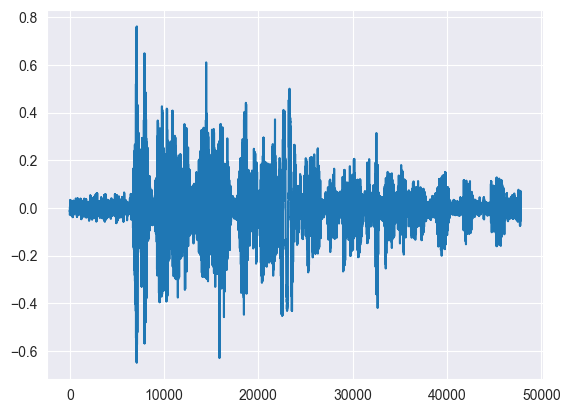

In [25]:
plt.plot(x_hat)

### HMICA

In [26]:
x.shape[0]

2

In [27]:
A_6_states = [
 [0.6500, 0.0700, 0.0700, 0.0700, 0.0700, 0.0700],
 [0.0700, 0.6500, 0.0700, 0.0700, 0.0700, 0.0700],
 [0.0700, 0.0700, 0.6500, 0.0700, 0.0700, 0.0700],
 [0.0700, 0.0700, 0.0700, 0.6500, 0.0700, 0.0700],
 [0.0700, 0.0700, 0.0700, 0.0700, 0.6500, 0.0700],
 [0.0700, 0.0700, 0.0700, 0.0700, 0.0700, 0.6500]]

A_4_states = [[0.6500, 0.1167, 0.1167, 0.1167],
 [0.1167, 0.6500, 0.1167, 0.1167],
 [0.1167, 0.1167, 0.6500, 0.1167],
 [0.1167, 0.1167, 0.1167, 0.6500]]

A_8_states = [[0.13973027, 0.13386568, 0.13333714, 0.13579208, 0.13440694,
        0.13308887, 0.13287611, 0.13465291],
       [0.10412742, 0.10859548, 0.10476808, 0.10534154, 0.10914522,
        0.10521875, 0.1044198 , 0.10627869],
       [0.15078655, 0.14964223, 0.15259674, 0.15167394, 0.1481522 ,
        0.15222692, 0.1506204 , 0.15044487],
       [0.15105721, 0.1505694 , 0.15021652, 0.15339789, 0.14988999,
        0.14975987, 0.14919956, 0.1477967 ],
       [0.09530228, 0.10013262, 0.09421756, 0.09487449, 0.10268576,
        0.09485968, 0.09501221, 0.09690556],
       [0.11948916, 0.11957914, 0.12241231, 0.12058465, 0.11836839,
        0.12351974, 0.11987699, 0.12036941],
       [0.10394578, 0.10263647, 0.10381163, 0.10242771, 0.1045389 ,
        0.10377071, 0.10928903, 0.10461909],
       [0.13332498, 0.1355698 , 0.13738528, 0.13381632, 0.13534361,
        0.13809963, 0.1402599 , 0.14091428]]


hmica = ParallelHMICALearner(
    k=5,  # number of states;  No-one, speaker 1, speaker 2 and both speakers (doubled to try to capture more acoustic information)
    m=2,  # number of sources
    x_dims=x.shape[0],
    use_gar=True,
    gar_order=10, # p = 8to12 should cover 1-1.5ms of speech context Speech has short-term correlations that span roughly 2-3ms
    update_interval=5,  # suggested by the paper
    learning_rates={
        'W': 1e-4,  # Unmixing matrix
        'R': 1e-3,  # Shape parameter
        'beta': 1e-3,  # Scale parameter
        'C': 1e-3  # GAR coefficients
    },
    use_analytical=False,
    # A = tf.convert_to_tensor(A_8_states)
)

history = hmica.train(tf.convert_to_tensor(x.astype('float32').T)
                      , hmm_max_iter=25, ica_max_iter=5000, hmm_tol=1e-6, ica_tol=1e-4)

  0%|          | 0/25 [00:00<?, ?it/s]

Function _compute_total_likelihood Took 0.0810 seconds


  4%|▍         | 1/25 [01:20<32:23, 80.98s/it]

Function _update_hmm_parameters Took 0.0628 seconds
Function _compute_total_likelihood Took 0.0560 seconds


  8%|▊         | 2/25 [02:28<28:02, 73.15s/it]

Function _update_hmm_parameters Took 0.0545 seconds
Function _compute_total_likelihood Took 0.0552 seconds


 12%|█▏        | 3/25 [03:17<22:48, 62.20s/it]

Function _update_hmm_parameters Took 0.0534 seconds
Function _compute_total_likelihood Took 0.0587 seconds


 16%|█▌        | 4/25 [04:09<20:15, 57.89s/it]

Function _update_hmm_parameters Took 0.0558 seconds
Function _compute_total_likelihood Took 0.0545 seconds


 20%|██        | 5/25 [04:57<18:09, 54.49s/it]

Function _update_hmm_parameters Took 0.0452 seconds
Function _compute_total_likelihood Took 0.0579 seconds


 24%|██▍       | 6/25 [05:27<14:33, 45.99s/it]

Function _update_hmm_parameters Took 0.0399 seconds
Function _compute_total_likelihood Took 0.0550 seconds


 28%|██▊       | 7/25 [06:00<12:31, 41.75s/it]

Function _update_hmm_parameters Took 0.0425 seconds
Function _compute_total_likelihood Took 0.0558 seconds


 32%|███▏      | 8/25 [06:37<11:24, 40.24s/it]

Function _update_hmm_parameters Took 0.0490 seconds
Function _compute_total_likelihood Took 0.0557 seconds


 36%|███▌      | 9/25 [07:17<10:45, 40.34s/it]

Function _update_hmm_parameters Took 0.0420 seconds
Function _compute_total_likelihood Took 0.0539 seconds


 40%|████      | 10/25 [08:05<10:40, 42.70s/it]

Function _update_hmm_parameters Took 0.0469 seconds
Function _compute_total_likelihood Took 0.0561 seconds


 44%|████▍     | 11/25 [08:43<09:36, 41.17s/it]

Function _update_hmm_parameters Took 0.0582 seconds
Function _compute_total_likelihood Took 0.0682 seconds


 48%|████▊     | 12/25 [09:07<07:46, 35.85s/it]

Function _update_hmm_parameters Took 0.0498 seconds
Function _compute_total_likelihood Took 0.0650 seconds


 52%|█████▏    | 13/25 [09:28<06:19, 31.61s/it]

Function _update_hmm_parameters Took 0.0322 seconds
Function _compute_total_likelihood Took 0.0557 seconds


 56%|█████▌    | 14/25 [09:51<05:17, 28.82s/it]

Function _update_hmm_parameters Took 0.0320 seconds
Function _compute_total_likelihood Took 0.0531 seconds


 60%|██████    | 15/25 [10:12<04:25, 26.59s/it]

Function _update_hmm_parameters Took 0.0322 seconds
Function _compute_total_likelihood Took 0.0519 seconds


 64%|██████▍   | 16/25 [10:34<03:45, 25.06s/it]

Function _update_hmm_parameters Took 0.0347 seconds
Function _compute_total_likelihood Took 0.0527 seconds


 68%|██████▊   | 17/25 [10:55<03:11, 23.98s/it]

Function _update_hmm_parameters Took 0.0384 seconds
Function _compute_total_likelihood Took 0.0525 seconds


 72%|███████▏  | 18/25 [11:17<02:42, 23.26s/it]

Function _update_hmm_parameters Took 0.0302 seconds
Function _compute_total_likelihood Took 0.0517 seconds


 76%|███████▌  | 19/25 [11:38<02:16, 22.69s/it]

Function _update_hmm_parameters Took 0.0336 seconds
Function _compute_total_likelihood Took 0.0524 seconds


 80%|████████  | 20/25 [12:00<01:51, 22.31s/it]

Function _update_hmm_parameters Took 0.0357 seconds
Function _compute_total_likelihood Took 0.0515 seconds


 84%|████████▍ | 21/25 [12:21<01:28, 22.09s/it]

Function _update_hmm_parameters Took 0.0348 seconds
Function _compute_total_likelihood Took 0.0504 seconds


 88%|████████▊ | 22/25 [12:42<01:05, 21.88s/it]

Function _update_hmm_parameters Took 0.0327 seconds
Function _compute_total_likelihood Took 0.0529 seconds


 92%|█████████▏| 23/25 [13:04<00:43, 21.73s/it]

Function _update_hmm_parameters Took 0.0327 seconds
Function _compute_total_likelihood Took 0.0520 seconds


 96%|█████████▌| 24/25 [13:26<00:21, 21.73s/it]

Function _update_hmm_parameters Took 0.0334 seconds
Function _compute_total_likelihood Took 0.0606 seconds


100%|██████████| 25/25 [13:47<00:00, 33.11s/it]

Function _update_hmm_parameters Took 0.0363 seconds
Function _compute_total_likelihood Took 0.0551 seconds
Converged ICA 2 in 750 iterations
Converged ICA 4 in 905 iterations
Converged ICA 1 in 5 iterations
Converged ICA 1 in 5 iterations
Converged ICA 4 in 491 iterations
Converged ICA 2 in 5 iterations
Converged ICA 3 in 5 iterations
Converged ICA 4 in 617 iterations
Converged ICA 2 in 5 iterations
Converged ICA 2 in 5 iterations
Converged ICA 4 in 5 iterations
Converged ICA 2 in 5 iterations
Converged ICA 1 in 5 iterations
Converged ICA 4 in 5 iterations
Converged ICA 2 in 5 iterations
Converged ICA 1 in 5 iterations
Converged ICA 2 in 738 iterations
Converged ICA 0 in 5 iterations
Converged ICA 0 in 5 iterations
Converged ICA 3 in 5 iterations
Converged ICA 4 in 641 iterations
Converged ICA 2 in 5 iterations
Converged ICA 3 in 5 iterations
Converged ICA 0 in 5 iterations
Converged ICA 3 in 5 iterations
Converged ICA 1 in 5 iterations
Converged ICA 3 in 5 iterations
Converged ICA 3 i

Text(0, 0.5, 'Log Likelihood')

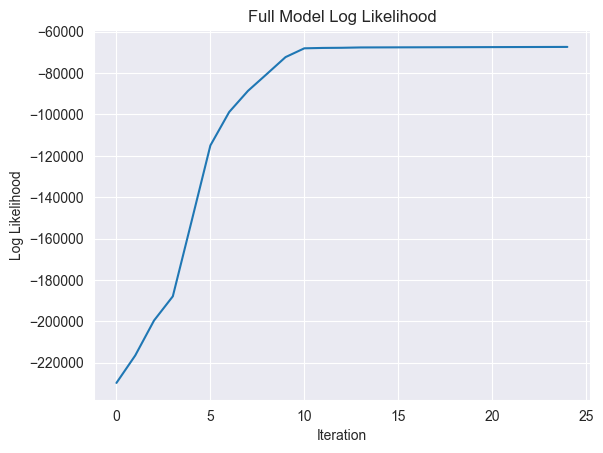

In [28]:
sns.lineplot(x=range(len(history['hmm_ll'])), y=history['hmm_ll'])

# Set the title and labels
plt.title("Full Model Log Likelihood")
plt.xlabel("Iteration")
plt.ylabel("Log Likelihood")

Text(0, 0.5, 'Log Likelihood')

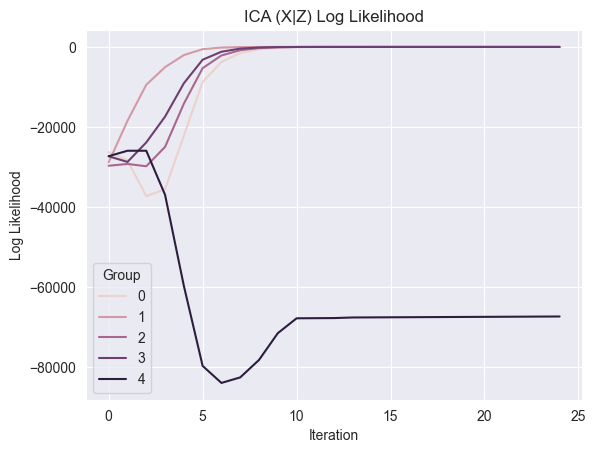

In [29]:
df_list = []
for group, values in history['ica_ll'].items():
    temp_df = pd.DataFrame({
        'Group': group,
        'Value': values,
        'Index': range(len(values))
    })
    df_list.append(temp_df)    
df = pd.concat(df_list, ignore_index=True)

sns.lineplot(data=df, x='Index', y='Value', hue='Group')

# Set the title and labels
plt.title("ICA (X|Z) Log Likelihood")
plt.xlabel("Iteration")
plt.ylabel("Log Likelihood")

In [30]:
obs_prob = lambda state, x: hmica.ica.compute_likelihood(x, state)
state_sequence, w_matrix = hmica.hmm.viterbi_for_inference(tf.convert_to_tensor(x.astype('float32').T), obs_prob)

In [31]:
sources_k = [hmica.ica.get_sources(tf.convert_to_tensor(x.astype('float32').T), k) for k in range(hmica.k)] 
sources_stacked = tf.stack(sources_k) 

In [32]:
reconstructed_sources = tf.einsum('tk,ktn->tn', state_sequence, sources_stacked)
reconstructed_sources = tf.transpose(reconstructed_sources)

In [33]:
Audio(reconstructed_sources[0].numpy(), rate=sr)

In [34]:
Audio(reconstructed_sources[1].numpy(), rate=sr)

In [35]:
tf.reduce_sum(state_sequence, axis=0)

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([    0.,     0.,     0.,     0., 47796.], dtype=float32)>

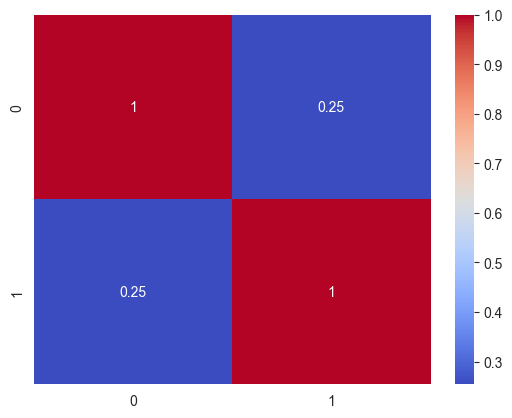

In [36]:
# Correlation between estimated Source
corr_matrix = np.corrcoef(reconstructed_sources.numpy())

# Create the heatmap
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.show()

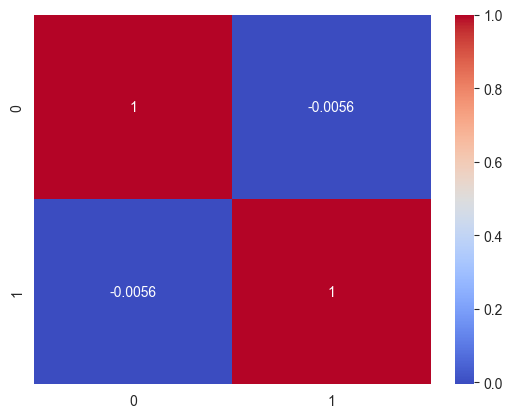

In [37]:
# Correlation between true Source
corr_matrix = np.corrcoef(tmp)

# Create the heatmap
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.show()

In [38]:
hmica.ica.W

[<tf.Variable 'unmixing_matrices_0:0' shape=(2, 2) dtype=float32, numpy=
 array([[-0.66431975, -0.22746255],
        [-0.20990205,  0.68210846]], dtype=float32)>,
 <tf.Variable 'unmixing_matrices_1:0' shape=(2, 2) dtype=float32, numpy=
 array([[-0.9166428 , -0.310866  ],
        [-0.29631686,  0.93221426]], dtype=float32)>,
 <tf.Variable 'unmixing_matrices_2:0' shape=(2, 2) dtype=float32, numpy=
 array([[-0.2789231 ,  0.8237938 ],
        [ 0.83716875,  0.24487871]], dtype=float32)>,
 <tf.Variable 'unmixing_matrices_3:0' shape=(2, 2) dtype=float32, numpy=
 array([[-0.26159218,  0.77076346],
        [ 0.78515595,  0.24782337]], dtype=float32)>,
 <tf.Variable 'unmixing_matrices_4:0' shape=(2, 2) dtype=float32, numpy=
 array([[ 0.00511616, -0.01309426],
        [-0.0130942 , -0.00491609]], dtype=float32)>]

In [39]:
hmica.hmm.transition_matrix, hmica.hmm.pi

(<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
 array([[1.4974738e-06, 1.2868016e-06, 1.4211786e-06, 1.3932929e-06,
         9.9999440e-01],
        [1.4989896e-06, 1.2896406e-06, 1.4218643e-06, 1.3952894e-06,
         9.9999440e-01],
        [1.4972015e-06, 1.2871175e-06, 1.4213716e-06, 1.3936594e-06,
         9.9999440e-01],
        [1.4978157e-06, 1.2878630e-06, 1.4214925e-06, 1.3944393e-06,
         9.9999440e-01],
        [1.4622871e-06, 1.2396139e-06, 1.4061955e-06, 1.3577616e-06,
         9.9999452e-01]], dtype=float32)>,
 <tf.Tensor: shape=(5,), dtype=float32, numpy=
 array([0.17118381, 0.18206786, 0.16613849, 0.16965732, 0.31095245],
       dtype=float32)>)

In [40]:
tf.reduce_sum(hmica.hmm.pi)

<tf.Tensor: shape=(), dtype=float32, numpy=0.9999998807907104>